# Options

In [39]:
# Paths
root = 'path to the root folder'
images_folder = root + 'subpath to the folder with the images'
save_path = root + 'models/'
table_path = root + 'subpath to multicare_multiplex.csv'
splits_path = root + 'subpath to multicare_splits.csv'
checkpoints = [
    root + 'subpath to the Imaging Type submodel (.pkl)',
    root + 'subpath to the Endoscopy submodel (.pkl)',
    root + 'subpath to the Pathology submodel (.pkl)',
    root + 'subpath to the Other Staining submodel (.pkl)',
    root + 'subpath to the Radiology submodel (.pkl)',
    root + 'subpath to the Ultrasound submodel (.pkl)']

# Predictions

In [38]:
from fastai.vision.all import *

In [40]:
# Get validation data
splits = pd.read_csv(splits_path)['is_valid'].values
data = pd.read_csv(table_path)[splits]
data['prediction'] = ''

# Get ground truth
def get_gt(x):
    gt = x['label_list_with_negative_classes'][1:-1]
    if ',' not in gt:
        return gt[1:-1]
    else:
        gt_list = x['imaging_type:radiology(main|attribute_angiography)'][1:-1].split(', ')
        if "'ultrasound'" in gt_list:
            return f"{x['imaging_type:radiology.ultrasound']} + {gt_list[1][1:-1]}".replace("no_angiography", "not_angiography")
        else:
            return f"{gt_list[0][1:-1]} + {gt_list[1][1:-1]}".replace("no_angiography", "not_angiography")
data['ground_truth'] = data.apply(get_gt, axis=1)

In [43]:
def get_rad(): pass
def get_ang(): pass
def combined_loss(): pass
def new_accuracy(): pass

combined_classes = np.array(['ct + angiography', 'ct + not_angiography', 'mri + angiography', 'mri + not_angiography', 'ultrasound + angiography', 'ultrasound + not_angiography', 'x_ray + angiography', 'x_ray + not_angiography'])
mapping = {
    (0, 0): 0,
    (0, 1): 1,
    (1, 0): 2,
    (1, 1): 3,
    (2, 0): 4,
    (2, 1): 5,
    (3, 0): 6,
    (3, 1): 7
}
def new_classes(x):
    # Convert input tensor to a tuple of integers
    key = tuple(x.int().tolist())
    # Return the mapped value or default to the first element of x
    return mapping.get(key, int(x[0].item()))    
def multioutput2multiclass(probs, ground_truths_1, ground_truths_2):
    probs = probs.cpu()
    rad_probs = probs[:,:4]
    ang_probs = probs[:,4:]
    rad_truths, ang_truths = ground_truths_1.cpu(), ground_truths_2.cpu()
    new_preds = []
    new_gts = []
    for rp, ap, rt, at in zip(rad_probs, ang_probs, rad_truths, ang_truths):
        # Get the id of the top prediction
        rad_pred, ang_pred = rp.argmax(), ap.argmax()
        pred = new_classes(torch.stack((rad_pred, ang_pred)))
        # gt = new_classes(torch.stack((rt, at)))
        new_preds.append(pred)
        # new_gts.append(gt)
    # return torch.Tensor(new_preds), torch.Tensor(new_gts)
    return torch.Tensor(new_preds), _

# Filter data
def filter_data(input_class):
    preds = data['prediction'].values
    use_ids = [(d == input_class) or ('ultrasound' in d and input_class=='ultrasound') for d in preds]
    return use_ids

# Return predictions
def predict(chk, ids):
    learn = load_learner(chk, cpu=False)
    test_dl = learn.dls.test_dl(np.array([f'{images_folder}{s[:4]}/{s[:6]}/{s}' for s in (data[ids]['file'].values)]))
    probs, _ = learn.get_preds(dl=test_dl)
    if 'Radiology' in chk:
        preds, _ = multioutput2multiclass(probs, torch.zeros_like(probs), torch.zeros_like(probs))
        preds = combined_classes[np.array(preds, dtype=int)]
    else:
        preds = np.array([learn.dls.vocab[prob.argmax()] for prob in probs])
    return preds

In [ ]:
input_classes = [
    '',
    'endoscopy',
    'pathology',
    'other_staining',
    'radiology',
    'ultrasound']

# Predict and save to table
for i, c in zip(input_classes, checkpoints):
    print(c)
    ids = filter_data(i)
    preds = predict(c, ids)
    if i=='ultrasound':
        data.loc[ids, 'prediction'] = [i+j for i,j in zip(preds,np.array([f' +{i.split('+')[1]}' for i in data.loc[ids, 'prediction'].values]))]
    else:
        data.loc[ids, 'prediction'] = preds

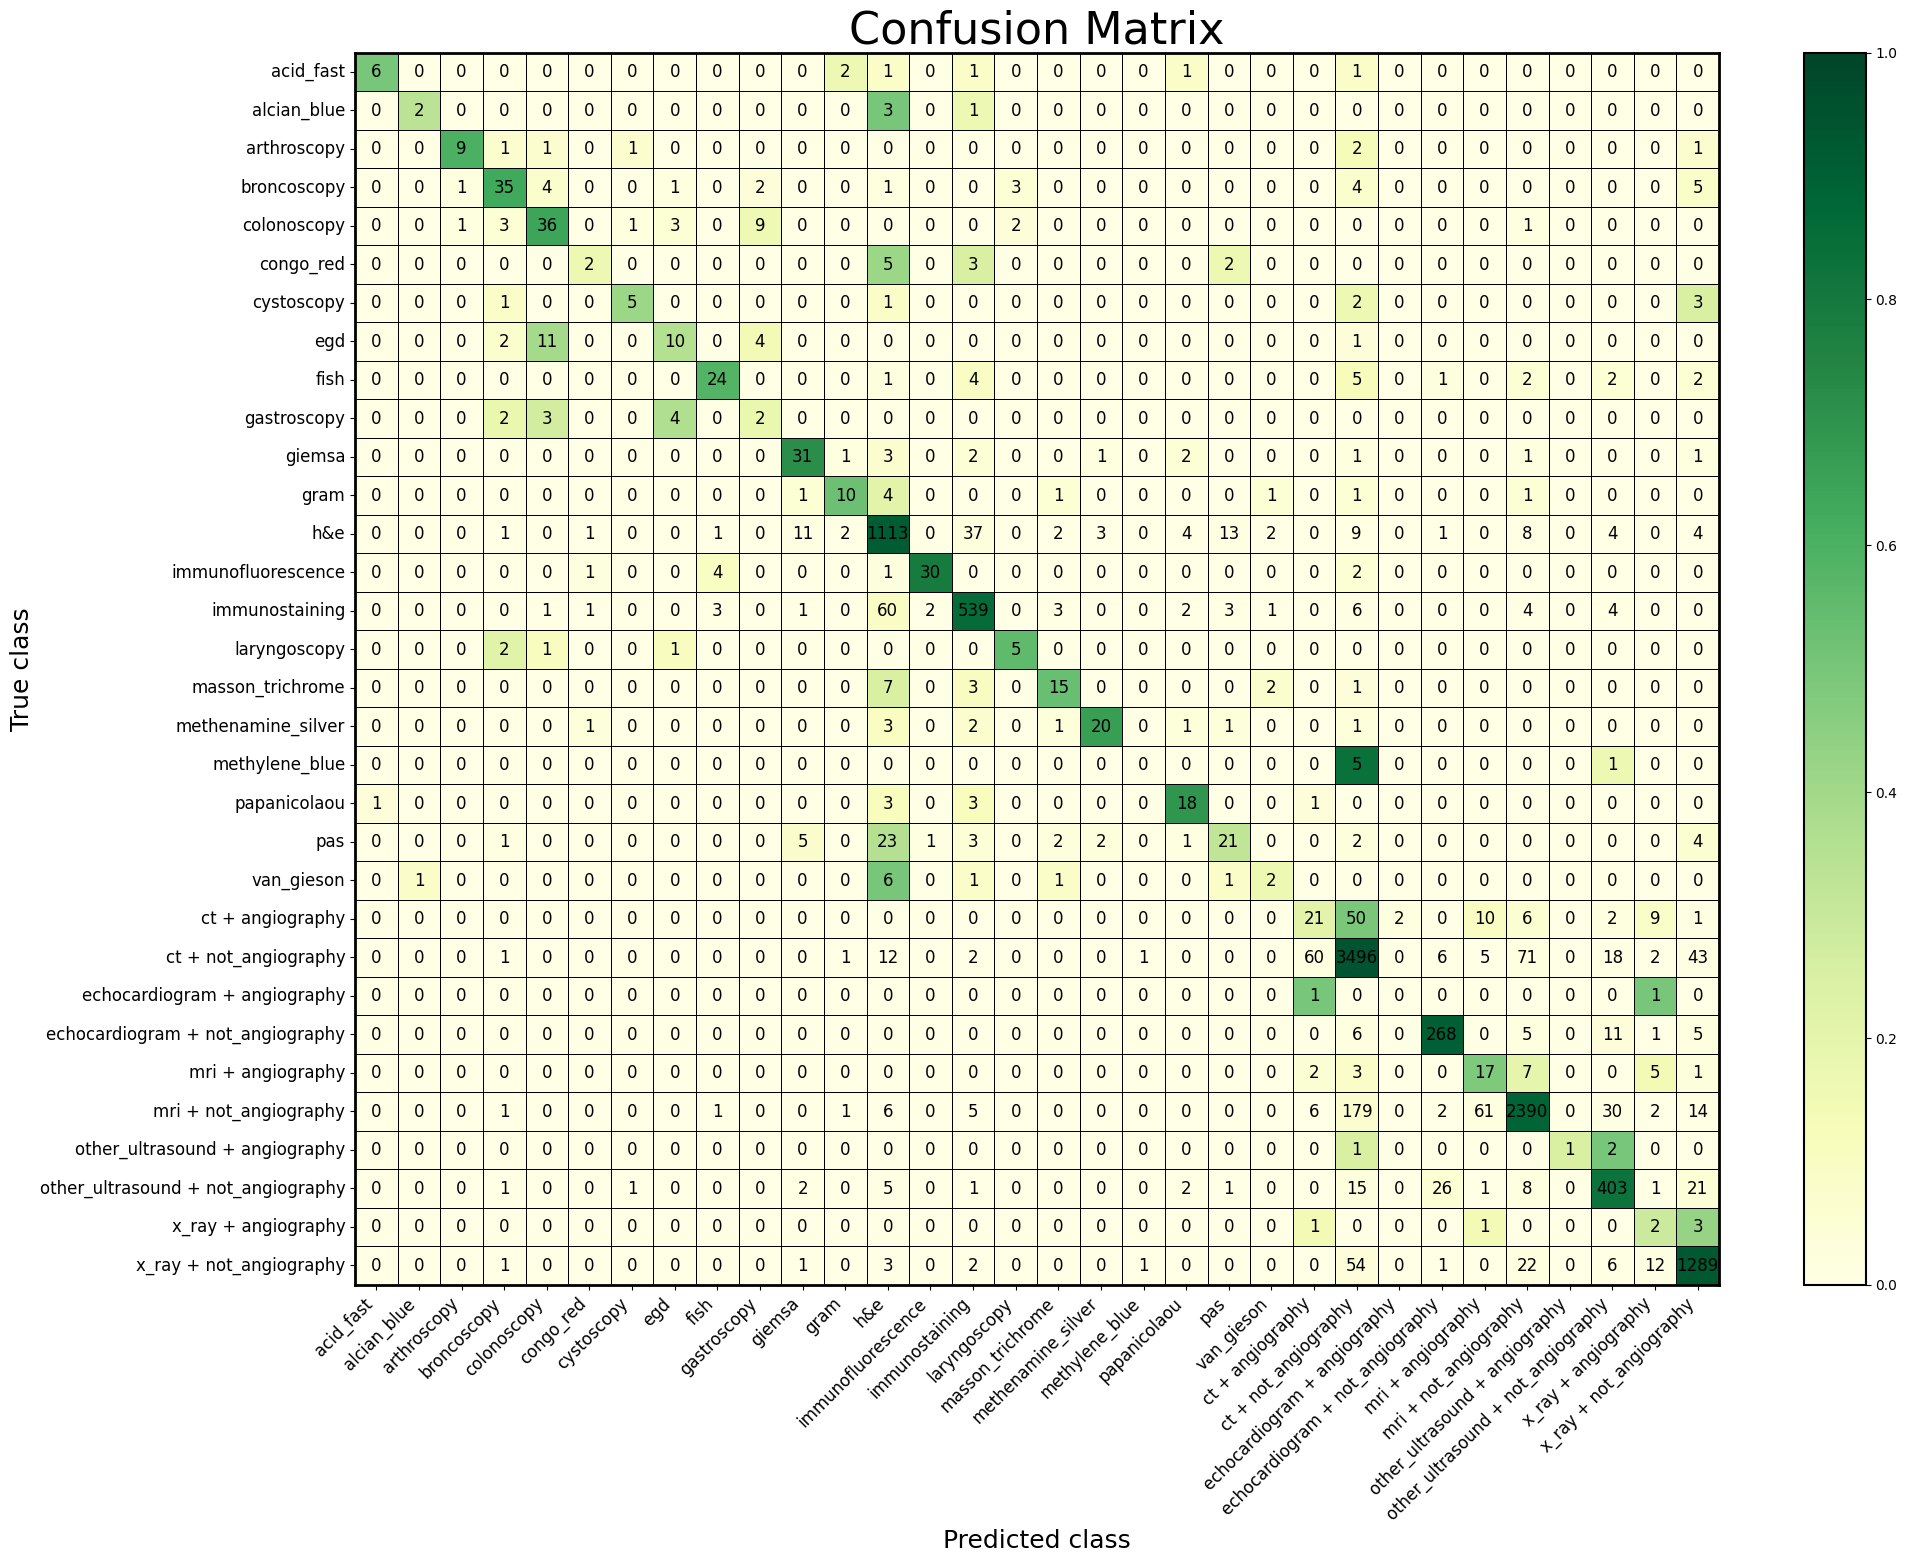

In [37]:
from sklearn.metrics import f1_score
from DLOlympus.training.plots import plot_confusion_matrix

preds = data['prediction'].values
truths = data['ground_truth'].values

results = {
    'accuracy': (preds == truths).mean(),
    'f1_score': f1_score(truths, preds, average='macro')}

_ = plot_confusion_matrix(truths, preds, np.append(np.array([i for i in np.unique(truths) if 'angiography' not in i]), np.array(['ct + angiography', 'ct + not_angiography', 'echocardiogram + angiography', 'echocardiogram + not_angiography','mri + angiography', 'mri + not_angiography', 'other_ultrasound + angiography', 'other_ultrasound + not_angiography', 'x_ray + angiography', 'x_ray + not_angiography'])), save_path, order_by_classes=True, figsize=(22,16))